### Computation Graph

Following Andrej Karpathy's tutorial, we are building the abstract data type to build the computational graph that will enable backpropagation throughout a network.  
This exercise complements my first goal of build a neural network entirely in numpy that is scalable. Every feature that I would want in a network will be implemented in numpy.

In [15]:
import numpy as np
import math

In [16]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # chain rule
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), label="exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

    def to_graphviz(self, graph):
        node_label = f"Value({self.label})"
        graph.node(node_label)
        for child in self._prev:
            child.to_graphviz(graph)
            graph.edge(child.get_node_label(), node_label)

    def get_node_label(self):
        return f"Value({self.label})"

In [17]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value(data=-8.0)

In [18]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### Example
We will run an example with our ADT to run do backprop thru a neuron

In [19]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

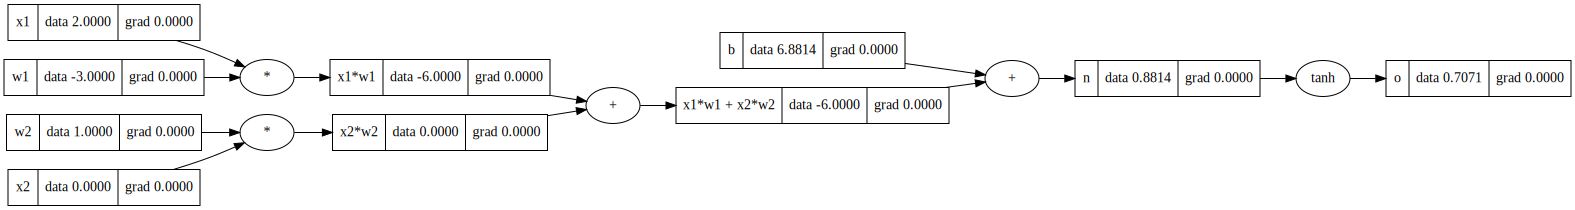

In [6]:
draw_dot(o)

In [7]:
o.backward()

### Let's attempt to backpropagate manually


\begin{align*}
o &= \tanh(n) \\
\frac{{do}}{{dn}} &= \frac{{d(\tanh(n))}}{{dn}} = 1 - \tanh**2(n) = 1 - o**2 \\
n &= x_1w_1 + x_2w_2 + b \\
\\
\frac{{d(n)}}{{d(x_1w_1 + x_2w_2)}} &= 1 && \frac{{d(n)}}{{db}} = 1 \\
\frac{{d(x_1w_1 + x_2w_2)}}{{d(x_2w_2)}} &= 1 && \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_1w_1)}} &= 1 \\
\frac{{d(x_2w_2)}}{{d(x_2)}} &= w_2 && \frac{{d(x_2w_2)}}{{d(w_2)}} &= x_2 \\
\frac{{d(x_1w_1)}}{{d(x_1)}} &= w_1 && \frac{{d(x_1w_1)}}{{d(w_1)}} &= x_1 \\
\\
\frac{{d(n)}}{{d(w_1)}} &= \frac{{d(n)}}{{d(x_1w_1 + x_2w_2)}} \cdot \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_1w_1)}} \cdot \frac{{d(x_1w_1)}}{{d(w_1)}} \\
 \frac{{dn}}{{d(x_2w_2)}} &= \frac{{dn}}{{d(x_1w_1 + x_2w_2)}} \cdot \frac{{d(x_1w_1 + x_2w_2)}}{{d(x_2w_2)}} = 1 \cdot 1 \\
\\
\frac{{dn}}{{dw_2}} &= x_2 && \frac{{dn}}{{dw_1}} &= x_1 \\
\frac{{dn}}{{dx_2}} &= w_2 && \frac{{dn}}{{dx_1}} &= w_1
\end{align*}


\[
\begin{align*}
\frac{{do}}{{dn}} &= 1 - o^2 \\
\frac{{do}}{{db}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{db}} = (1 - o^2) \cdot 1 \\
\frac{{do}}{{dx_1}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dx_1}} = (1 - o^2) \cdot w_1 \\
\frac{{do}}{{dx_2}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dx_2}} = (1 - o^2) \cdot w_2 \\
\frac{{do}}{{dw_1}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_1}} = (1 - o^2) \cdot x_1 \\
\frac{{do}}{{dw_2}} &= \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_2}} = (1 - o^2) \cdot x_2 \\
\end{align*}
\]


In [8]:
o.grad = 1.0
w1.grad = x1.data * (1 - o.data**2)
x1.grad = w1.data * (1 - o.data**2)
w2.grad = x2.data * (1 - o.data**2)
x2.grad = w2.data * (1 - o.data**2)
x1w1.grad = 1 * (1 - o.data**2)
x2w2.grad = 1 * (1 - o.data**2)
x1w1x2w2.grad = 1 * (1 - o.data**2)
n.grad = 1 - o.data**2
b.grad = 1 * (1 - o.data**2)

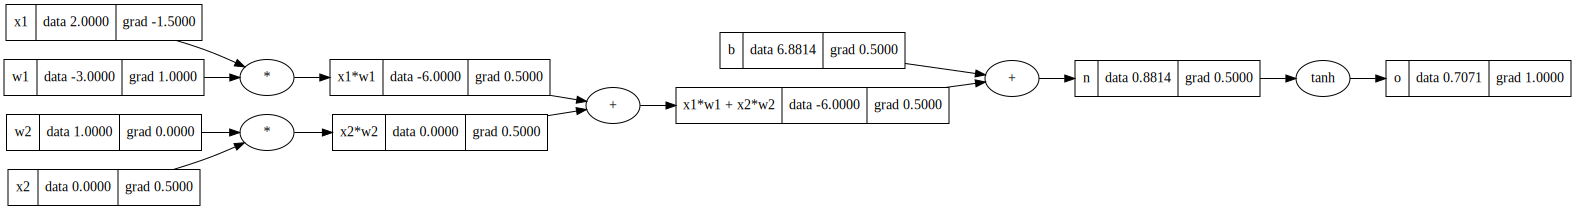

In [9]:
draw_dot(o)

### Backtracking the tree to verify our manual backprop


\begin{align*}
\text{Backpropagation of a Node } v_i : \sum_{j \in Ch(v_i)} \bar{v_j} \frac{\partial v_j}{\partial v_i}  \\
o &= \tanh(n) \\
o.\text{grad} &= 1 \\
n.\text{grad} &= (1 - o^2) = \text{n.grad} \\
b.\text{grad} &= \frac{{d(n \rightarrow o)}}{{db}} = \text{n.grad} \cdot \frac{{dn}}{{db}} = \text{n.grad} \\
(x_1w_1 + x_2w_2).\text{grad} &= \text{n.grad} \cdot 1 \\
(x_2w_2).\text{grad} &= (x_1w_1 + x_2w_2).\text{grad} \cdot 1 \\
(x_1w_1).\text{grad} &= (x_1w_1 + x_2w_2).\text{grad} \cdot 1 \\
w_1.\text{grad} &= \frac{{do}}{{dw_1}} = \frac{{do}}{{dn}} \cdot \frac{{dn}}{{dw_1}} = \frac{{do}}{{dn}} \cdot \frac{{dn}}{{x_1w_1}} \cdot \frac{{dx_1w_1}}{{dw_1}} = \text{n.grad} \cdot x_1.\text{data} = (x_1w_1).\text{grad} \cdot x_1.\text{data} \\
x_1.\text{grad} &= o.\text{grad} \cdot \text{n.grad} \cdot (x_1w_1 + x_2w_2).\text{grad} \cdot (x_1w_1).\text{grad} = (x_1w_1).\text{grad} \cdot w_1.\text{data}
\end{align*}
\]

### Backtracking through the tree with the ._backward attribute

In [10]:
o.grad = 1.0  # base case

In [11]:
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

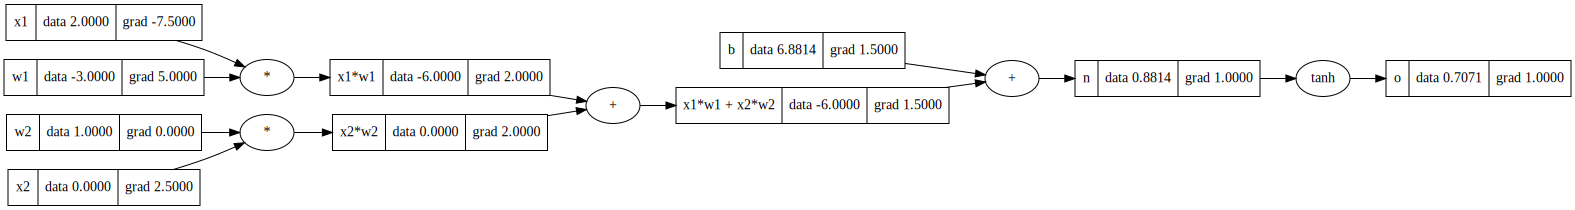

In [12]:
draw_dot(o)

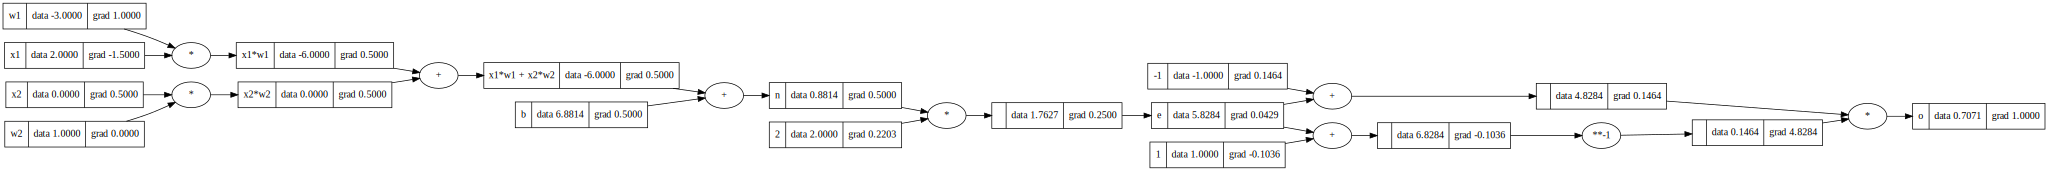

In [13]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# ----
e = (2 * n).exp()
e.label = "e"
o = (e - 1) / (e + 1)
# ----
o.label = "o"
o.backward()
draw_dot(o)

### Multi Layer Perceptron Design

In [20]:
from typing import Any


class Neuron:
    def __init__(self, nin) -> None:
        self.nin = nin
        self.w = [
            Value(np.random.uniform(-1, 1), label=f"w_{i}")
            for i, _ in enumerate(range(self.nin))
        ]
        self.b = Value(np.random.uniform(-1, 1), label="b")

    def __call__(self, x):
        # tanh(w*x +b)
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nouts: list) -> None:
        self.neurons = [Neuron(nin) for _ in range(nouts)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
import random

In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8450633169163618)

In [22]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [8]:
epoch = 100
loss_list = []
for i in range(epoch):
    ## fw pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    loss_list.append(loss.data)

    ## Backprop
    loss.backward()

    ## Gradient Descent
    for p in n.parameters():
        p.data += -0.01 * p.grad

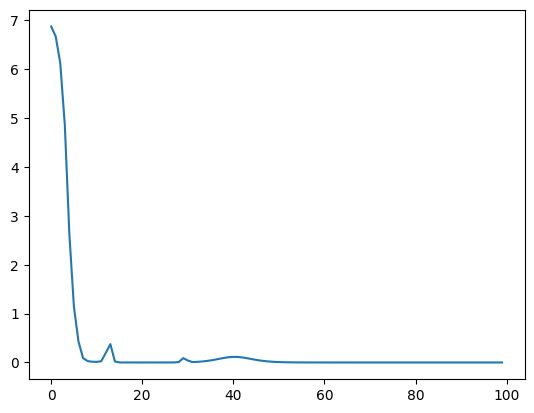

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_list)